# Desplegando el modelo   

Ahora que se tiene un modelo bien entrenado, es hora de utilizarlo. En este notebook, se expondrán nuevas imágenes al modelo guardado y se detectarán las letras correctas del alfabeto de la lengua de signos.

## Objetivos

* Cargar desde disco un modelo ya entrenado
* Reformatear imágenes para un modelo entrenado con imágenes de formato diferente.
* Realizar inferencias con imágenes nuevas, nunca vistas por el modelo entrenado y evaluar su rendimiento.

## Cargando el modelo entrenado
En este nuevo notebook, se va a cargar el modelo guardado y entrenado previamente. Se va a cargar el modelo seleccionando el fichero `*.keras`generado en el notebook anterior (07_RNA_Data_Augmentation.ipynb).

In [1]:
from tensorflow import keras

model = keras.models.load_model('asl_model.keras')

2025-03-13 12:01:14.853368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741867274.874196   31856 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741867274.878997   31856 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-13 12:01:14.897238: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-13 12:01:22.078101: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL

Si es necesario comprobar que todo esté correcto, se puede volver a ver el resumen del modelo.

In [2]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 75)     │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 75)     │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 50)     │        33,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 50)     │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 25)       │        11,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 25)       │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 25)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       205,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │        12,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 527,800 (2.01 MB)

 Trainable params: 263,749 (1.01 MB)

 Non-trainable params: 300 (1.17 KB)

 Optimizer params: 263,751 (1.01 MB)

## Preparando una imagen para el modelo

Ahora es el momento de utilizar el modelo para hacer predicciones sobre nuevas imágenes que nunca ha visto antes (*inferencia*). Se proporciona un conjunto de imágenes en la carpeta datasets/asl_images. Es necesario abrirla utilizando el navegador de la izquierda y explorar las imágenes.

Se puede observar que las imágenes que existen tienen una resolución mucho mayor que las imágenes del conjunto de datos. También son en color. Hay que recordar que las imágenes en el conjunto de datos eran de 28x28 píxeles y en escala de grises.    

Es importante tener en cuenta que siempre que se hacen predicciones con un modelo, la entrada debe coincidir con la forma de los datos con los que se entrenó el modelo. Para este modelo, el conjunto de datos de entrenamiento tenía la forma: (27455, 28, 28, 1). Esto correspondía a 27455 imágenes de 28 por 28 píxeles cada una con un canal de color (escala de grises). 

### Mostrando las imágenes

Cuando se vaya a utilizar el modelo para hacer predicciones sobre nuevas imágenes, será útil mostrar también la imagen. Para ello, se puede utilizar la librería `matplotlib`.

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')

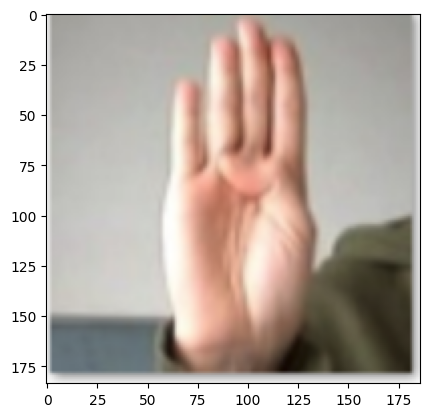

In [4]:
show_image('./datasets/asl_images/b.png')

### Escalado de las imágenes

Las imágenes del dataset eran de 28x28 píxeles y en escala de grises. Es necesario garantizar que se va pasar el mismo tamaño e imágenes en escala de grises al método de predicción. Hay algunas maneras de editar imágenes con Python, pero Keras tiene una utilidad integrada que funciona bien, tal y como se muestra a continuación:

In [5]:
from tensorflow.keras.preprocessing import image as image_utils

def load_and_scale_image(image_path):
    image = image_utils.load_img(image_path, color_mode="grayscale", target_size=(28,28))
    return image

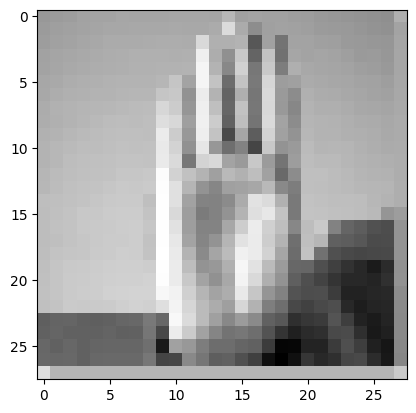

In [6]:
image = load_and_scale_image('datasets/asl_images/b.png')
plt.imshow(image, cmap='gray')

### Preparación de la imagen para realizar la predicción

Ahora se dispone de una imagen en escala de grises de 28x28 píxeles, ya casi está preparada para pasarla al modelo de predicción. Primero se debe remodelar la imagen para que coincida con la forma del dataset con el que se ha entrenado el modelo. Para ello, hay que convertir la imagen a un formato más rudimentario. Se utilizará una utilidad de keras llamada `image_to_array`, como se muestra a continuación:

In [7]:
image = image_utils.img_to_array(image)

Ahora se puede remodelar la imagen para prepararla para la predicción.

In [8]:
# Este reshape corresponde a 1 imagen de 28x28 pixeles con un canal de color
image = image.reshape(1,28,28,1) 

Por último, hay que recordar normalizar los datos (haciendo que todos los valores estén entre 0-1), como se hizo con el conjunto de datos de entrenamiento:

In [9]:
image = image / 255

## Predicción   

Ahora se debe pasar la imagen preprocesada al método de predicción del modelo. 

In [10]:
prediction = model.predict(image)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
[[2.7727081e-16 1.0000000e+00 2.0202344e-21 1.2057365e-25 4.2289030e-18
  1.1636607e-12 1.2016459e-24 1.4917021e-22 3.8013090e-09 1.6647871e-22
  3.2929889e-22 3.4006383e-18 4.8316175e-20 4.8538818e-26 2.5889621e-20
  4.2139547e-20 1.0467472e-25 4.4264909e-28 5.2323000e-28 3.7012761e-15
  9.7591281e-28 7.5598727e-14 9.0814163e-15 7.7751426e-19]]


### Entendiendo la predicción

Las predicciones tienen el formato de una matriz de 24 elementos. Aunque parece un poco diferente, es el mismo formato que las matrices categóricas «binarizadas» de `y_train` y `y_test`. Cada elemento de la matriz es una probabilidad entre 0 y 1, que representa la confianza para cada categoría.

Se debe encontrar qué elemento de la matriz representa la probabilidad más alta. Esto se puede hacer fácilmente con la librería `numpy` y la función [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html).

A continuación, el código que se necesita para ello:

In [11]:
import numpy as np
np.argmax(prediction)

np.int64(1)

Cada elemento de la matriz de predicción representa una letra posible del alfabeto de la lengua de signos. Se debe recordar que j y z no son opciones porque implican mover la mano, y sólo se está tratando con fotos fijas.    
Se construye una correspondencia entre el índice de la matriz de predicciones y la letra correspondiente. 

In [13]:
# El alfabeto no contiene j o z porque requieren movimiento
alphabet = "abcdefghiklmnopqrstuvwxy"

Ahora se puede pasar el índice de predicción para encontrar la letra correspondiente.

In [14]:
alphabet[np.argmax(prediction)]

'b'

## Ejercicio: juntándolo todo

Se debe ponerlo todo en una función para que se pueda hacer predicciones sólo a partir del archivo de imagen.    
Por tanto, se debe implementar en la función de abajo usando las funciones y pasos anteriores. Si se requiere ayuda, se puede revelar la solución desplegando la celda de debajo.

In [15]:
def predict_letter(file_path):
    # Mostrar imagen
    show_image(file_path) 
    
    # Cargar imagen y escalar
    image = load_and_scale_image(file_path)
    plt.imshow(image, cmap='gray')

    # Conversion de imagen a array
    image = image_utils.img_to_array(image)

    # Reshape de imagen
    image = image.reshape(1,28,28,1) 

    # Normalizar imagen
    image = image / 255
    
    # Realizar prediccion
    prediction = model.predict(image)
    print(prediction)
    
    # Convertir prediccion a letra
    predicted_letter = alphabet[np.argmax(prediction)]
    
    # Retornar letra
    return predicted_letter   

## Solución

Despliega la celda de debajo.

In [16]:
# SOLUCIÓN
def predict_letter(file_path):
    show_image(file_path)
    image = load_and_scale_image(file_path)
    image = image_utils.img_to_array(image)
    image = image.reshape(1,28,28,1) 
    image = image/255
    prediction = model.predict(image)
    # CONVERTIR PREDICCIÓN A LETRA
    predicted_letter = alphabet[np.argmax(prediction)]
    return predicted_letter

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


'b'

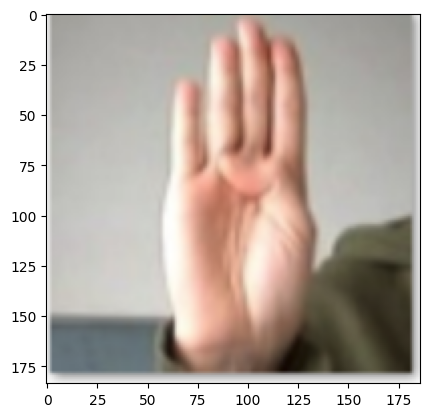

In [17]:
predict_letter("datasets/asl_images/b.png")

Si se utiliza también la función con la letra 'a' en el dataset asl_images:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


'a'

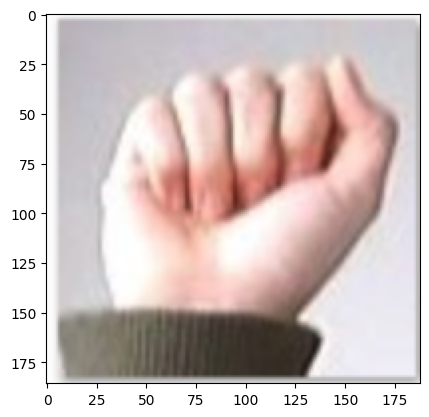

In [18]:
predict_letter("datasets/asl_images/a.png")